# Build a conditional VAE on CIFAR-10 that can generate images of 10 classes

[Benchmark](https://paperswithcode.com/sota/image-generation-on-cifar-10)

Ref.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch_directml
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from typing import Type
from ignite.engine import Engine, Events
from PIL import Image

## Setup device

In [2]:
for i in range(torch_directml.device_count()):
    print(i, ":", torch_directml.device_name(i))

dml = torch_directml.device(1)
print("dml =", dml)

device = dml

0 : Radeon RX 5500M
1 : AMD Radeon(TM) Graphics
dml = privateuseone:1


## Load data

In [3]:
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Variables

In [4]:
# Variables
classes = training_data.classes
class_size = len(classes)
chanel_num = 3
image_size = 32
train_loss_history = []
test_loss_history = []
fid_value_history = []
fid_values = []

# Hyperparameters
batch_size = 64
epochs = 5
latent_size = 20
training = True

In [5]:
from torch.utils.data import DataLoader, random_split

training_data.data = training_data.data.astype("uint8")
test_data.data = test_data.data.astype("uint8")

s1, s2 = random_split(training_data, [0.8, 0.2], torch.Generator().manual_seed(42))

kwargs = {"num_workers": 1, "pin_memory": True}

train_loader = DataLoader(s1, batch_size=batch_size, shuffle=True, **kwargs)
validate_loader = DataLoader(s2, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

## Show some samples

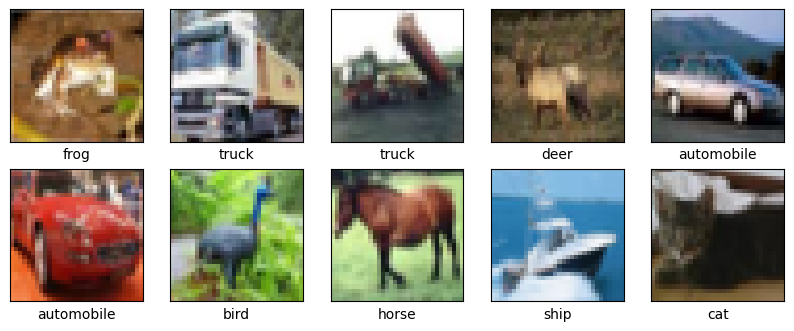

In [6]:
def plot_cifar10_images(images, labels, n):
    plt.figure(figsize=[10, 10])

    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

    plt.show()


plot_cifar10_images(training_data.data, training_data.targets, 10)

## Data shape

In [7]:
print("Training images shape: ", training_data.data.shape)
print("Test images shape: ", test_data.data.shape)

Training images shape:  (50000, 32, 32, 3)
Test images shape:  (10000, 32, 32, 3)


## Build cVAE model

[cVAE mechanism](https://idiotdeveloper.com/introduction-to-autoencoders/)

![cVAE mechanism](./images/variational-autoencoder.png)

Ref.

[Understanding Conditional Variational Autoencoders](https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8)

[Conditional Variational Autoencoder (cVAE) using PyTorch](https://github.com/unnir/cVAE)

[Conditional Variational Autoencoder in Keras](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

[GAN Evaluation : the Frechet Inception Distance and Inception Score metrics](https://colab.research.google.com/github/pytorch-ignite/pytorch-ignite.ai/blob/gh-pages/blog/2021-08-11-GAN-evaluation-using-FID-and-IS.ipynb#scrollTo=Stp59yfH65VO)

In [8]:
from torchinfo import summary


class CVAE(nn.Module):
    """
    主要包含三個結構
    1. encoder
    2. reparameterizer
    3. decoder
    """

    def __init__(self, feature_size, latent_size, class_size, *args, **kwargs) -> None:
        super(CVAE, self).__init__(*args, **kwargs)

        self.feature_size = feature_size
        self.class_size = class_size

        # encoder
        self.fc1 = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decoder
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c):  # Q(z|x, c)
        """
        x: (bs, feature_size)
        c: (bs, class_size)
        """
        inputs = torch.cat([x, c], 1)  # (bs, feature_size + class_size)
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):  # P(x|z, c)
        """
        z: (bs, latent_size)
        c: (bs, class_size)
        """
        inputs = torch.cat([z, c], 1)  # (bs, latent_size + class_size)
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, self.feature_size), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar


model = CVAE(image_size * image_size * chanel_num, latent_size, class_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

summary(
    model.to("cpu"),
    input_size=[(batch_size, chanel_num, image_size, image_size), (batch_size, class_size)],
    device="cpu",
)

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [64, 3072]                --
├─Linear: 1-1                            [64, 400]                 1,233,200
├─ReLU: 1-2                              [64, 400]                 --
├─Linear: 1-3                            [64, 20]                  8,020
├─Linear: 1-4                            [64, 20]                  8,020
├─Linear: 1-5                            [64, 400]                 12,400
├─ReLU: 1-6                              [64, 400]                 --
├─Linear: 1-7                            [64, 3072]                1,231,872
├─Sigmoid: 1-8                           [64, 3072]                --
Total params: 2,493,512
Trainable params: 2,493,512
Non-trainable params: 0
Total mult-adds (M): 159.58
Input size (MB): 0.79
Forward/backward pass size (MB): 2.00
Params size (MB): 9.97
Estimated Total Size (MB): 12.77

## Loss function & one-hot encoding

In [9]:
def loss_function(recon_x, x, mu, logvar):
    """Reconstruction + KL divergence losses summed over all elements and batch

    See Appendix B from VAE paper:

    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114

    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size * image_size * chanel_num), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def one_hot_encode(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

## Train and test step

In [10]:
def train_step(epoch, data_loader: Type[DataLoader]):
    model.train()
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot_encode(labels, class_size)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()

        # log
        if batch_idx % 20 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(data_loader.dataset),
                    100.0 * batch_idx / len(data_loader),
                    loss.item() / len(data),
                ),
                end="\r",
            )

    print(
        "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch,
            (batch_idx + 1) * len(data),
            len(data_loader.dataset),
            100.0 * batch_idx / len(data_loader),
            loss.item() / len(data),
        ),
        end="\r\n",
    )

    train_loss /= len(data_loader.dataset)
    train_loss_history.append(train_loss)
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss))


def test_step(epoch, data_loader: Type[DataLoader]):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            data, labels = data.to(device), labels.to(device)
            labels = one_hot_encode(labels, class_size)
            recon_batch, mu, logvar = model(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()

    test_loss /= len(data_loader.dataset)
    test_loss_history.append(test_loss)
    print("====> Test set loss: {:.4f}".format(test_loss))

## FID evaluation

Inception v3 model architecture

![Inception v3 architecture](./images/inception_v3.png)

In [11]:
from torcheval.metrics import FrechetInceptionDistance


def interpolate(batch):
    """
    Inception v3 model 需要輸入為 299 * 299 * 3
    所以需要先將 32 * 32 * 3 的 cifar-10 資料重新調整大小
    """
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def generate_images(generate_size):
    """從隨機分布中生成指定數量的圖片"""
    model.eval()

    with torch.no_grad():
        c = torch.eye(generate_size, class_size).to(device)
        noises_z = torch.randn(generate_size, latent_size).to(device)
        samples = model.decode(noises_z, c).cpu()
        gen_images = samples.view(generate_size, chanel_num, image_size, image_size)

        return gen_images


fid_metric = FrechetInceptionDistance().to("cpu")


def fid_evaluation(engine: Engine, batch_data):

    gen_images = generate_images(len(batch_data))

    n = min(len(batch_data), 5)

    gen = interpolate(gen_images[:n])
    real = interpolate(batch_data[0][:n])

    fid_metric.update(real, is_real=True)
    fid_metric.update(gen, is_real=False)
    fid_value = fid_metric.compute()

    return {"fid": fid_value}


fid_evaluator = Engine(fid_evaluation)


@fid_evaluator.on(Events.ITERATION_COMPLETED)
def log_fid_evaluation(engine: Engine):
    o = engine.state.output
    fid_value = o["fid"]
    fid_values.append(fid_value)

    print(
        "Iteration {}/{}    FID: {:.4f}".format(engine.state.iteration, len(engine.state.dataloader), fid_value),
        end="\r",
    )


@fid_evaluator.on(Events.EPOCH_COMPLETED)
def log_epoch_evaluation(engine: Engine):
    average_fid_value = np.mean(fid_values)
    fid_value_history.append(average_fid_value)
    fid_metric.reset()
    fid_values.clear()

    print("\n====> Average FID: {:.4f}".format(average_fid_value))

## Training

In [12]:
model.to(device)

for epoch in range(1, epochs + 1):
    train_step(epoch, train_loader)
    test_step(epoch, validate_loader if training else test_loader)
    fid_evaluator.run(validate_loader if training else test_loader)

c:\Users\User\Desktop\Deep_Learning\.venv\lib\site-packages\torch\nn\functional.py:3098: UserWarning: The operator 'aten::binary_cross_entropy' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at D:\a\_work\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch._C._nn.binary_cross_entropy(input, target, weight, reduction_enum)


Train Epoch: 1 [40000/40000 (100%)]	Loss: 2147.087402
====> Epoch: 1 Average loss: 2146.5167
====> Test set loss: 2146.5362
Iteration 157/157    FID: 375.9253
====> Average FID: 385.3192
Train Epoch: 2 [40000/40000 (100%)]	Loss: 2146.666016
====> Epoch: 2 Average loss: 2146.5778
====> Test set loss: 2146.6105
Iteration 157/157    FID: 378.4892
====> Average FID: 380.8451
Train Epoch: 3 [40000/40000 (100%)]	Loss: 2146.657715
====> Epoch: 3 Average loss: 2146.5896
====> Test set loss: 2146.6355
Iteration 157/157    FID: 363.9993
====> Average FID: 369.9597
Train Epoch: 4 [40000/40000 (100%)]	Loss: 2146.327637
====> Epoch: 4 Average loss: 2146.5643
====> Test set loss: 2146.5372
Iteration 157/157    FID: 373.6029
====> Average FID: 381.8156
Train Epoch: 5 [40000/40000 (100%)]	Loss: 2145.776855
====> Epoch: 5 Average loss: 2146.5673
====> Test set loss: 2146.5573
Iteration 157/157    FID: 382.3139
====> Average FID: 393.5390


## Result insights

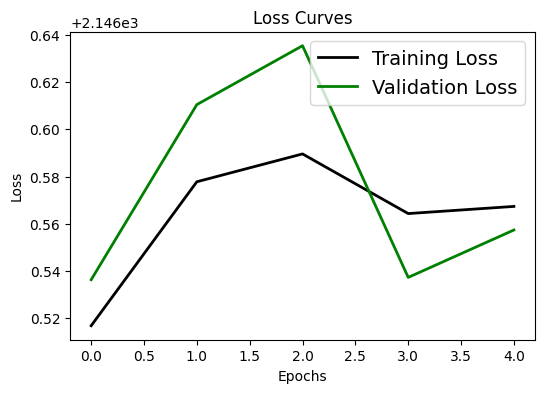

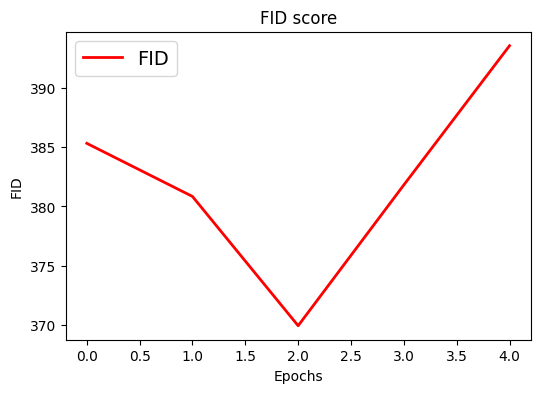

In [16]:
if training:
    # For loss
    plt.figure(figsize=[6, 4])
    plt.plot(train_loss_history, "black", linewidth=2.0)
    plt.plot(test_loss_history, "green", linewidth=2.0)
    plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title("Loss Curves", fontsize=12)

    # For FID
    plt.figure(figsize=[6, 4])
    plt.plot(fid_value_history, "red", linewidth=2.0)
    plt.legend(["FID"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("FID", fontsize=10)
    plt.title("FID score", fontsize=12)

    plt.show()